# import libraries 

In [28]:
%pip install seaborn
%pip install nltk
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import warnings
warnings.filterwarnings("ignore")

# 📥 Data Loading & Overview

In [29]:
train_df = pd.read_csv('/drive/twitter_training.csv')  # Replace with your file path
val_df = pd.read_csv('/drive/twitter_validation.csv') 

In [30]:
train_df.head()

,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [31]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74681 entries, 0 to 74680
Data columns (total 4 columns):
 #   Column                                                 Non-Null Count  Dtype 
---  ------                                                 --------------  ----- 
 0   2401                                                   74681 non-null  int64 
 1   Borderlands                                            74681 non-null  object
 2   Positive                                               74681 non-null  object
 3   im getting on borderlands and i will murder you all ,  73995 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.4+ MB


In [32]:
train_df.columns = ['Tweet_ID', 'Entity', 'Sentiment', 'Tweet_Content']
train_df.head()

,Tweet_ID,Entity,Sentiment,Tweet_Content
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


# 🧹 Data Cleaning & Preprocessing

In [33]:
train_df.isna().sum()

Tweet_ID           0
Entity             0
Sentiment          0
Tweet_Content    686
dtype: int64

In [34]:
train_df = train_df.dropna(subset=['Tweet_Content'])
train_df.isna().sum()

Tweet_ID         0
Entity           0
Sentiment        0
Tweet_Content    0
dtype: int64

In [35]:
train_df['Tweet_Content'].value_counts()

Tweet_Content
                                                                                                                                                                                                                                                                      172
It is not the first time that the EU Commission has taken such a step.                                                                                                                                                                                                172
At the same time, despite the fact that there are currently some 100 million people living below the poverty line, most of them do not have access to health services and do not have access to health care, while most of them do not have access to health care.    172
<unk>                                                                                                                                                                                       

In [36]:
import pandas as pd
import re
import string

# Minimal stopword list (you can expand this list)
stop_words = set([
    'a', 'an', 'the', 'is', 'are', 'this', 'that', 'and', 'or', 'not',
    'in', 'on', 'at', 'for', 'to', 'of', 'with', 'from', 'by', 'about',
    'as', 'be', 'been', 'has', 'have', 'had', 'will', 'would', 'can',
    'could', 'should', 'i', 'you', 'he', 'she', 'it', 'we', 'they', 'them',
    'my', 'your', 'his', 'her', 'its', 'our', 'their', 'me', 'us'
])

def preprocess_text(text):
    text = text.lower()
    
    # Remove emojis
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"
        u"\U0001F300-\U0001F5FF"
        u"\U0001F680-\U0001F6FF"
        u"\U0001F1E0-\U0001F1FF"
        u"\U00002500-\U00002BEF"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"
        u"\u3030"
        "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)

    # Clean links, mentions, unknown tokens, numbers
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'@\S+', '', text)
    text = re.sub(r'<unk>', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Remove stopwords
    text = ' '.join([word for word in text.split() if word not in stop_words])
    
    return text if text else None

# Example usage
# train_df = pd.DataFrame({'Tweet_Content': ["This is a test 😊", "Check this out: https://example.com"]})
train_df['clean_text'] = train_df['Tweet_Content'].apply(preprocess_text)
train_df = train_df.dropna(subset=['clean_text'])

# View results
print(train_df['clean_text'].value_counts())


clean_text
first time eu commission taken such step.                                                                                                                                                                      172
same time, despite fact there currently some million people living below poverty line, most do access health services do access health care, while most do access health care.                                 172
wow                                                                                                                                                                                                             81
.                                                                                                                                                                                                               75
wtf                                                                                                                                              

In [37]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
train_df['Sentiment'] = le.fit_transform(train_df['Sentiment'])

# 🧼 Exploratory Data Analysis (EDA)

## 1. Count plot for Sentiment Classes 

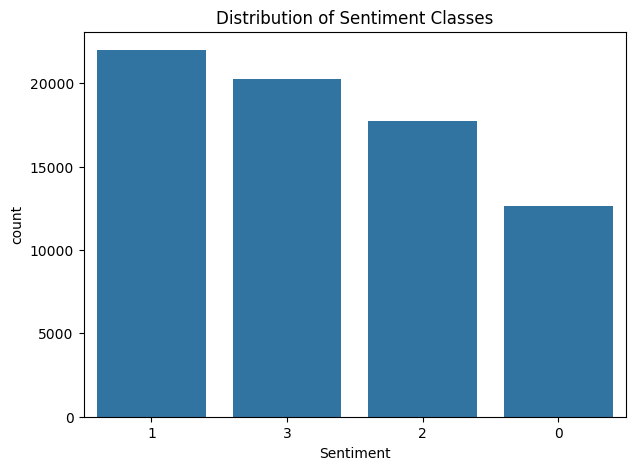

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(7,5))
sns.countplot(data=train_df, x='Sentiment', order=train_df['Sentiment'].value_counts().index)
plt.title('Distribution of Sentiment Classes')
plt.show()


 ## 2. Word Cloud Visualization for Each Sentiment

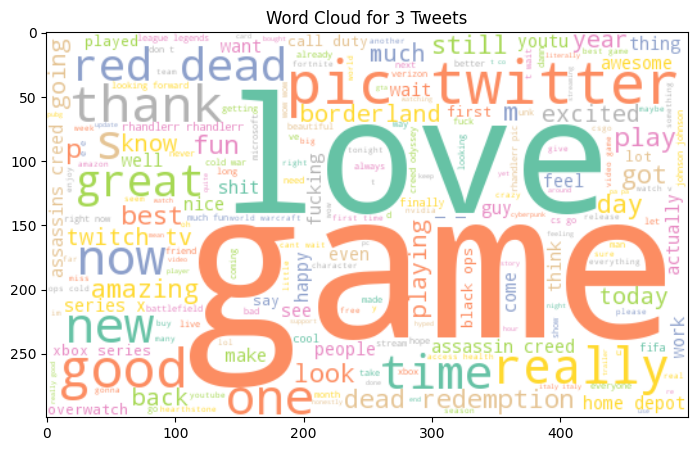

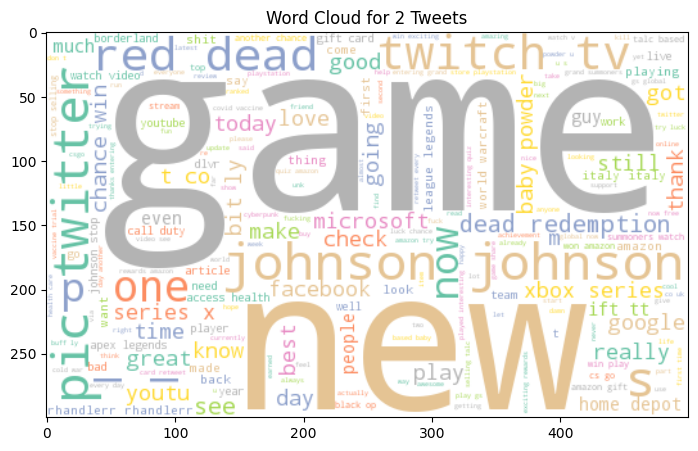

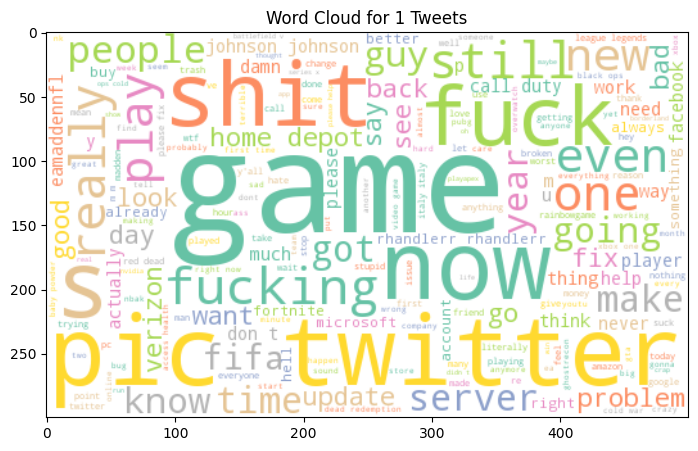

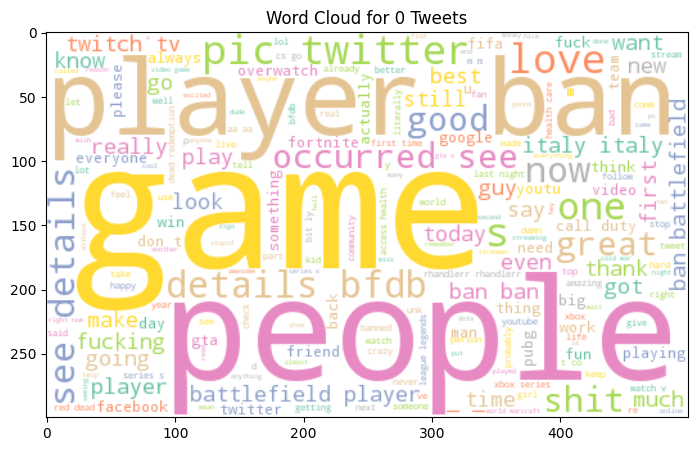

In [39]:
from wordcloud import WordCloud

def plot_wordcloud(sentiment_label):
    text = ' '.join(train_df[train_df['Sentiment'] == sentiment_label]['clean_text'].dropna())
    wordcloud = WordCloud(width=500, height=300, background_color='white', colormap='Set2').generate(text)

    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {sentiment_label} Tweets')
    plt.show()

for sentiment in train_df['Sentiment'].unique():
    plot_wordcloud(sentiment)


## 3. Comparison of Tweet Length Before and After Cleaning

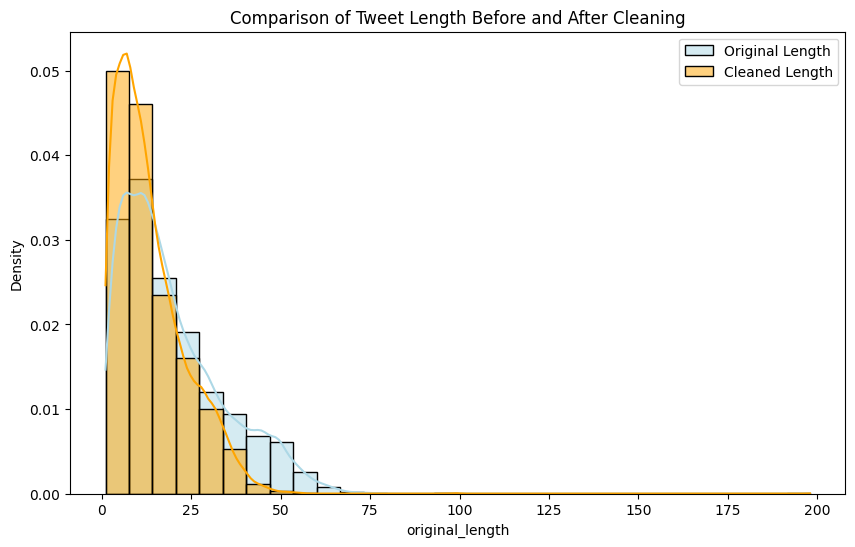

In [40]:
train_df['original_length'] = train_df['Tweet_Content'].apply(lambda x: len(str(x).split()))
train_df['cleaned_length'] = train_df['clean_text'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(10,6))
sns.histplot(train_df['original_length'], color='lightblue', kde=True, label='Original Length', bins=30, stat='density')
sns.histplot(train_df['cleaned_length'], color='orange', kde=True, label='Cleaned Length', bins=30, stat='density')

plt.title('Comparison of Tweet Length Before and After Cleaning')
plt.legend()
plt.show()


# 🧠 Text Vectorization

In [41]:
x = train_df['clean_text']
y = train_df['Sentiment']


In [42]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [43]:
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1,3)) # uses 10000 importent features and uses 1 word or w wod together
x_train_vec = vectorizer.fit_transform(x_train)
x_test_vec = vectorizer.transform(x_test)

# 🤖 Model Training & Evaluation

In [44]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Naive Bayes": MultinomialNB(),
    "Random Forest": RandomForestClassifier()
}

In [ ]:
for name, model in models.items():
    print(f"\nTraining: {name}")
    model.fit(x_train_vec, y_train)
    y_pred = model.predict(x_test_vec)
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred, target_names=le.classes_))


Training: Logistic Regression
Accuracy: 0.7374
              precision    recall  f1-score   support

  Irrelevant       0.73      0.58      0.64      2555
    Negative       0.74      0.83      0.78      4419
     Neutral       0.73      0.70      0.71      3511
    Positive       0.74      0.77      0.75      4037

    accuracy                           0.74     14522
   macro avg       0.74      0.72      0.72     14522
weighted avg       0.74      0.74      0.73     14522


Training: Naive Bayes
Accuracy: 0.6740
              precision    recall  f1-score   support

  Irrelevant       0.77      0.38      0.51      2555
    Negative       0.65      0.83      0.73      4419
     Neutral       0.71      0.58      0.64      3511
    Positive       0.65      0.77      0.70      4037

    accuracy                           0.67     14522
   macro avg       0.70      0.64      0.65     14522
weighted avg       0.69      0.67      0.66     14522


Training: Random Forest


# 🔧 Use val_df for Evaluation

## 1. preprocessing   

In [ ]:
val_df.info()

In [ ]:
val_df.columns = ['Tweet_ID', 'Entity', 'Sentiment', 'Tweet_Content']

In [ ]:
val_df = val_df.dropna(subset=['Tweet_Content'])

val_df['clean_text'] = val_df['Tweet_Content'].apply(preprocess_text)

In [ ]:
val_df.head()

In [ ]:
val_df['Sentiment']=le.fit_transform(val_df['Sentiment'])

In [ ]:
val_df = val_df.dropna(subset=['clean_text']) 

In [ ]:
x_val = vectorizer.transform(val_df['clean_text'])
y_val = val_df['Sentiment']


# Evaluation on validation data 

In [ ]:
best_model = RandomForestClassifier()
best_model.fit(x_train_vec, y_train)

In [ ]:
y_val_pred = best_model.predict(x_val)

# Evaluate
val_acc = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {val_acc:.4f}")
print("Validation Classification Report:")
print(classification_report(y_val, y_val_pred, target_names=le.classes_))